In [ ]:
# Import Required Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

# Neural Network libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [12]:
# Data Loading and Preprocessing

# Load the dataset
df = pd.read_csv('data/Wifi_train_dataset.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())

# Parse RSSI and MAC address strings into lists
rssi_lists = df['rssi'].apply(lambda x: [float(v) for v in x.split(',')])
mac_lists = df['mac_addrs_idx'].apply(lambda x: [int(v) for v in x.split(',')])

# Find all unique MAC addresses to create fixed-length feature space
all_macs = set()
for mac_list in mac_lists:
    all_macs.update(mac_list)
all_macs = sorted(list(all_macs))
n_macs = len(all_macs)

print(f"\nFound {n_macs} unique MAC addresses (access points)")

# Create mapping from MAC address to column index
mac_to_idx = {mac: idx for idx, mac in enumerate(all_macs)}

# Create fixed-length feature matrix (one column per MAC address)
n_samples = len(df)
X = np.full((n_samples, n_macs), np.nan)  # Initialize with NaN

for i in range(n_samples):
    rssi_vals = rssi_lists.iloc[i]
    mac_vals = mac_lists.iloc[i]
    
    # Populate feature vector at correct MAC positions
    for rssi, mac in zip(rssi_vals, mac_vals):
        col_idx = mac_to_idx[mac]
        X[i, col_idx] = rssi

print(f"\nCreated feature matrix: {X.shape}")
print(f"NaN values: {np.isnan(X).sum():,} ({100 * np.isnan(X).sum() / X.size:.2f}% of total)")

# Impute with -100 dB (no signal indicator)
X_imputed = np.nan_to_num(X, nan=-100.0)
print(f"Imputed NaN values with -100 dB (no signal indicator)")

# Remove low-variance features (APs that are almost always -100)
print("\n" + "="*60)
print("FEATURE SELECTION")
print("="*60)
variance_threshold = VarianceThreshold(threshold=1.0)
X_selected = variance_threshold.fit_transform(X_imputed)
n_features_removed = n_macs - X_selected.shape[1]

print(f"Removed {n_features_removed} low-variance features")
print(f"Remaining features: {X_selected.shape[1]}")

# Add engineered features
print("\nAdding engineered features...")

# Feature 1: Number of APs detected (non -100 values)
n_aps_detected = np.sum(X_imputed > -100, axis=1).reshape(-1, 1)

# Feature 2: Mean RSSI of detected APs
mean_rssi = np.zeros((n_samples, 1))
for i in range(n_samples):
    detected = X_imputed[i, X_imputed[i] > -100]
    mean_rssi[i] = detected.mean() if len(detected) > 0 else -100

# Feature 3: Max RSSI (strongest signal)
max_rssi = np.max(X_imputed, axis=1).reshape(-1, 1)

# Feature 4: Std of detected RSSI values
std_rssi = np.zeros((n_samples, 1))
for i in range(n_samples):
    detected = X_imputed[i, X_imputed[i] > -100]
    std_rssi[i] = detected.std() if len(detected) > 1 else 0

# Combine original features with engineered features
X_enhanced = np.hstack([X_selected, n_aps_detected, mean_rssi, max_rssi, std_rssi])

print(f"Added 4 engineered features")
print(f"Total features: {X_enhanced.shape[1]}")
print(f"  - Number of APs detected")
print(f"  - Mean RSSI of detected APs")
print(f"  - Maximum RSSI (strongest signal)")
print(f"  - Standard deviation of RSSI")

# Prepare targets
y = df[['x', 'y']]

# Split data into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_enhanced, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

# Feature Scaling
print("\n" + "="*60)
print("FEATURE SCALING")
print("="*60)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Features scaled using StandardScaler")
print(f"Training features shape: {X_train_scaled.shape}")
print(f"Validation features shape: {X_val_scaled.shape}")
print("="*60)

Dataset shape: (2880, 4)

First few rows:
           x          y                                               rssi  \
0  39.300458 -33.832626  -76,-84,-76,-78,-76,-79,-79,-76,-83,-46,-46,-4...   
1  45.667780 -17.235028  -81,-82,-82,-82,-65,-65,-65,-65,-71,-71,-71,-7...   
2  79.944219 -54.821975  -88,-88,-88,-88,-78,-78,-78,-78,-67,-66,-66,-6...   
3  57.353449 -30.499641  -88,-91,-91,-61,-61,-61,-62,-88,-92,-92,-79,-9...   
4  54.454364 -16.056419  -84,-88,-84,-88,-84,-88,-84,-88,-83,-82,-82,-8...   

                                       mac_addrs_idx  
0  68,251,65,46,66,47,48,78,183,95,96,97,143,212,...  
1  126,127,128,129,59,56,57,60,86,85,58,87,120,12...  
2  1,2,3,4,290,289,288,291,5,6,7,8,23,21,152,154,...  
3  113,114,115,1,2,3,4,184,185,186,78,76,119,81,5...  
4  45,68,46,65,47,66,48,78,95,98,96,97,59,56,57,6...  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880 entries, 0 to 2879
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dt

In [13]:
# Task i: Multi-Linear Regression Model

print("="*60)
print("TASK i: DEVELOPING MULTI-LINEAR REGRESSION MODEL")
print("="*60)

# Build separate models for X and Y coordinates
model_x = LinearRegression()
model_y = LinearRegression()

# Train the models on scaled training data
model_x.fit(X_train_scaled, y_train['x'])
model_y.fit(X_train_scaled, y_train['y'])

print("\n✓ Models trained successfully!")
print(f"  Model X: {len(model_x.coef_)} coefficients, Intercept: {model_x.intercept_:.4f}")
print(f"  Model Y: {len(model_y.coef_)} coefficients, Intercept: {model_y.intercept_:.4f}")
print("="*60)

TASK i: DEVELOPING MULTI-LINEAR REGRESSION MODEL

✓ Models trained successfully!
  Model X: 511 coefficients, Intercept: 48.9199
  Model Y: 511 coefficients, Intercept: -27.4464


TASK ii: MODEL PERFORMANCE ON VALIDATION SET

Mean Squared Error (X coordinate): 19.5869
Mean Squared Error (Y coordinate): 24.2969

>>> Overall Mean Squared Error: 21.9419 <<<

Additional Metrics:
  RMSE (X coordinate): 4.4257
  RMSE (Y coordinate): 4.9292
  Overall RMSE: 4.6842

  R² Score (X coordinate): 0.8989
  R² Score (Y coordinate): 0.7789

------------------------------------------------------------
Sample Predictions vs Actual Values (First 5)
------------------------------------------------------------
 Actual_X  Predicted_X  Error_X   Actual_Y  Predicted_Y  Error_Y
59.779089    58.001068 1.778021 -30.530006   -33.949645 3.419639
55.781606    57.747001 1.965395 -18.976056   -21.204903 2.228848
30.571793    26.415049 4.156744 -37.548512   -43.316734 5.768222
39.217118    35.444118 3.772999 -34.819949   -32.764593 2.055355
51.736434    49.047557 2.688877 -33.385827   -27.954801 5.431026

Generating visualization...


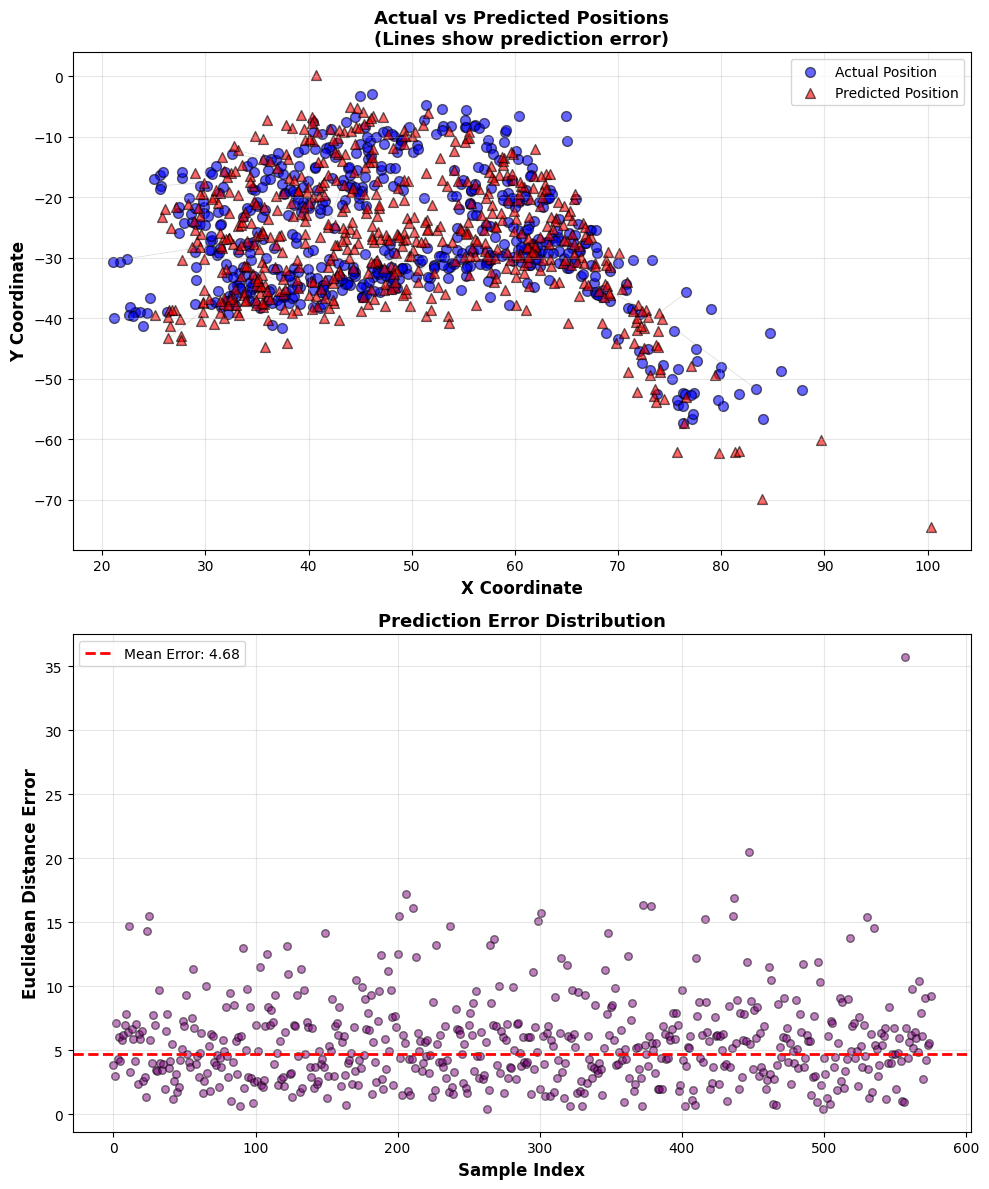

✓ Visualization complete!


In [17]:
# Task ii: Report Model Performance on Validation Set

print("="*60)
print("TASK ii: MODEL PERFORMANCE ON VALIDATION SET")
print("="*60)

# Make predictions on validation set
y_pred_x = model_x.predict(X_val_scaled)
y_pred_y = model_y.predict(X_val_scaled)

# Calculate Mean Squared Error for each coordinate
mse_x = mean_squared_error(y_val['x'], y_pred_x)
mse_y = mean_squared_error(y_val['y'], y_pred_y)

# Calculate overall MSE (average of both coordinates)
mse_overall = (mse_x + mse_y) / 2

print(f"\nMean Squared Error (X coordinate): {mse_x:.4f}")
print(f"Mean Squared Error (Y coordinate): {mse_y:.4f}")
print(f"\n>>> Overall Mean Squared Error: {mse_overall:.4f} <<<")
print("="*60)

# Additional metrics
rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)
rmse_overall = np.sqrt(mse_overall)

print(f"\nAdditional Metrics:")
print(f"  RMSE (X coordinate): {rmse_x:.4f}")
print(f"  RMSE (Y coordinate): {rmse_y:.4f}")
print(f"  Overall RMSE: {rmse_overall:.4f}")

# Calculate R² scores
r2_x = r2_score(y_val['x'], y_pred_x)
r2_y = r2_score(y_val['y'], y_pred_y)

print(f"\n  R² Score (X coordinate): {r2_x:.4f}")
print(f"  R² Score (Y coordinate): {r2_y:.4f}")

# Display some sample predictions
print("\n" + "-"*60)
print("Sample Predictions vs Actual Values (First 5)")
print("-"*60)
comparison = pd.DataFrame({
    'Actual_X': y_val['x'].values[:5],
    'Predicted_X': y_pred_x[:5],
    'Error_X': np.abs(y_val['x'].values[:5] - y_pred_x[:5]),
    'Actual_Y': y_val['y'].values[:5],
    'Predicted_Y': y_pred_y[:5],
    'Error_Y': np.abs(y_val['y'].values[:5] - y_pred_y[:5])
})
print(comparison.to_string(index=False))
print("="*60)

# Visualization: Predicted vs Actual Positions
print("\nGenerating visualization...")

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot 1: 2D Position Scatter (Actual vs Predicted)
ax1 = axes[0]
ax1.scatter(y_val['x'], y_val['y'], alpha=0.6, s=50, c='blue', label='Actual Position', edgecolors='black')
ax1.scatter(y_pred_x, y_pred_y, alpha=0.6, s=50, c='red', marker='^', label='Predicted Position', edgecolors='black')

# Draw lines connecting actual to predicted for first 50 points (to avoid clutter)
for i in range(min(50, len(y_val))):
    ax1.plot([y_val['x'].values[i], y_pred_x[i]], 
             [y_val['y'].values[i], y_pred_y[i]], 
             'gray', alpha=0.3, linewidth=0.5)

ax1.set_xlabel('X Coordinate', fontsize=12, fontweight='bold')
ax1.set_ylabel('Y Coordinate', fontsize=12, fontweight='bold')
ax1.set_title('Actual vs Predicted Positions\n(Lines show prediction error)', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Residual Plot
ax2 = axes[1]
errors = np.sqrt((y_val['x'].values - y_pred_x)**2 + (y_val['y'].values - y_pred_y)**2)
ax2.scatter(range(len(errors)), errors, alpha=0.5, s=30, c='purple', edgecolors='black')
ax2.axhline(y=rmse_overall, color='red', linestyle='--', linewidth=2, label=f'Mean Error: {rmse_overall:.2f}')
ax2.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Euclidean Distance Error', fontsize=12, fontweight='bold')
ax2.set_title('Prediction Error Distribution', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualization complete!")

EXPLORING MODEL IMPROVEMENTS WITH ELASTICNET

ElasticNet combines Ridge (L2) and Lasso (L1) regularization
to balance feature selection with stability.

Training ElasticNet models with cross-validation...
✓ Best alpha for X: 0.07, L1 ratio: 0.50
✓ Best alpha for Y: 0.04, L1 ratio: 0.90

ElasticNet MSE (X): 16.5948
ElasticNet MSE (Y): 20.9380
ElasticNet Overall MSE: 18.7664

ElasticNet selected 293/511 features for X
ElasticNet selected 280/511 features for Y

COMPARISON: Linear Regression vs ElasticNet
Model                          MSE (X)         MSE (Y)         Overall MSE    
---------------------------------------------------------------------------
Linear Regression              19.5869         24.2969         21.9419        
ElasticNet                     16.5948         20.9380         18.7664        

✓ Improvement: 14.47% reduction in MSE
✓ ElasticNet achieved better generalization through regularization


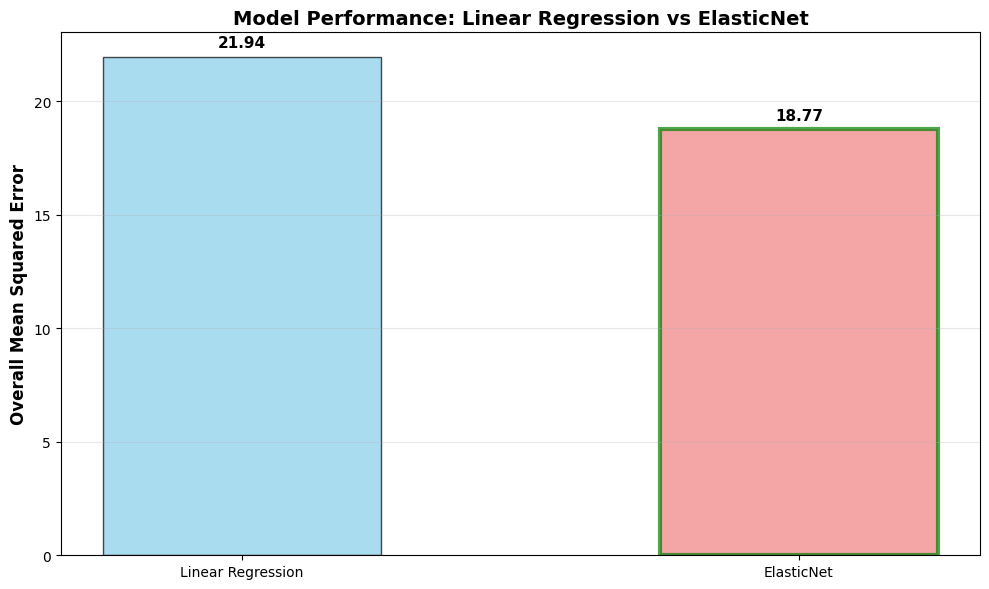


💡 Key Insight:
   ElasticNet's hybrid L1+L2 regularization reduces overfitting
   by performing feature selection while maintaining stability.


In [15]:
# Potential Improvement: ElasticNet with Cross-Validation

print("="*60)
print("EXPLORING MODEL IMPROVEMENTS WITH ELASTICNET")
print("="*60)

print("\nElasticNet combines Ridge (L2) and Lasso (L1) regularization")
print("to balance feature selection with stability.\n")

# Define range of alpha values to test
alphas = np.logspace(-2, 3, 50)

# ElasticNet with cross-validation
print("Training ElasticNet models with cross-validation...")
elastic_cv_x = ElasticNetCV(alphas=alphas, cv=5, max_iter=10000, l1_ratio=[0.1, 0.5, 0.7, 0.9])
elastic_cv_y = ElasticNetCV(alphas=alphas, cv=5, max_iter=10000, l1_ratio=[0.1, 0.5, 0.7, 0.9])

elastic_cv_x.fit(X_train_scaled, y_train['x'])
elastic_cv_y.fit(X_train_scaled, y_train['y'])

print(f"✓ Best alpha for X: {elastic_cv_x.alpha_:.2f}, L1 ratio: {elastic_cv_x.l1_ratio_:.2f}")
print(f"✓ Best alpha for Y: {elastic_cv_y.alpha_:.2f}, L1 ratio: {elastic_cv_y.l1_ratio_:.2f}")

# Make predictions
y_pred_elastic_x = elastic_cv_x.predict(X_val_scaled)
y_pred_elastic_y = elastic_cv_y.predict(X_val_scaled)

# Calculate MSE
mse_elastic_x = mean_squared_error(y_val['x'], y_pred_elastic_x)
mse_elastic_y = mean_squared_error(y_val['y'], y_pred_elastic_y)
mse_elastic_overall = (mse_elastic_x + mse_elastic_y) / 2

print(f"\nElasticNet MSE (X): {mse_elastic_x:.4f}")
print(f"ElasticNet MSE (Y): {mse_elastic_y:.4f}")
print(f"ElasticNet Overall MSE: {mse_elastic_overall:.4f}")

# Count non-zero coefficients (feature selection)
non_zero_elastic_x = np.sum(elastic_cv_x.coef_ != 0)
non_zero_elastic_y = np.sum(elastic_cv_y.coef_ != 0)
print(f"\nElasticNet selected {non_zero_elastic_x}/{len(elastic_cv_x.coef_)} features for X")
print(f"ElasticNet selected {non_zero_elastic_y}/{len(elastic_cv_y.coef_)} features for Y")

# Compare with baseline
print("\n" + "="*60)
print("COMPARISON: Linear Regression vs ElasticNet")
print("="*60)
print(f"{'Model':<30} {'MSE (X)':<15} {'MSE (Y)':<15} {'Overall MSE':<15}")
print("-"*75)
print(f"{'Linear Regression':<30} {mse_x:<15.4f} {mse_y:<15.4f} {mse_overall:<15.4f}")
print(f"{'ElasticNet':<30} {mse_elastic_x:<15.4f} {mse_elastic_y:<15.4f} {mse_elastic_overall:<15.4f}")
print("="*60)

improvement = ((mse_overall - mse_elastic_overall) / mse_overall) * 100
print(f"\n✓ Improvement: {improvement:.2f}% reduction in MSE")
print(f"✓ ElasticNet achieved better generalization through regularization")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Linear Regression', 'ElasticNet']
mse_values = [mse_overall, mse_elastic_overall]
colors = ['skyblue', 'lightcoral']

bars = ax.bar(models, mse_values, color=colors, edgecolor='black', alpha=0.7, width=0.5)

# Highlight best model
best_idx = mse_values.index(min(mse_values))
bars[best_idx].set_edgecolor('green')
bars[best_idx].set_linewidth(3)

ax.set_ylabel('Overall Mean Squared Error', fontsize=12, fontweight='bold')
ax.set_title('Model Performance: Linear Regression vs ElasticNet', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(mse_values):
    ax.text(i, v + 0.3, f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n💡 Key Insight:")
print("   ElasticNet's hybrid L1+L2 regularization reduces overfitting")
print("   by performing feature selection while maintaining stability.")

## 2.2 Neural Network Model for Indoor Localization

In [ ]:
# Task i: Define Neural Network Architecture

print("="*60)
print("SECTION 2.2 - TASK i: NEURAL NETWORK MODEL DEFINITION")
print("="*60)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def create_deep_nn_with_batchnorm(input_dim):
    """
    Deep Neural Network with Batch Normalization
    
    Architecture:
    - Input Layer: 511 features
    - Hidden Layer 1: 256 neurons + BatchNorm + Dropout(0.3)
    - Hidden Layer 2: 128 neurons + BatchNorm + Dropout(0.3)
    - Hidden Layer 3: 64 neurons + BatchNorm + Dropout(0.2)
    - Hidden Layer 4: 32 neurons
    - Output Layer: 2 neurons (X, Y coordinates)
    
    Total Parameters: ~200K
    """
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=(input_dim,)),
        
        # Layer 1: 256 neurons
        layers.Dense(256, activation='relu', 
                    kernel_regularizer=regularizers.l2(0.001),
                    name='dense_1'),
        layers.BatchNormalization(name='batch_norm_1'),
        layers.Dropout(0.3, name='dropout_1'),
        
        # Layer 2: 128 neurons
        layers.Dense(128, activation='relu', 
                    kernel_regularizer=regularizers.l2(0.001),
                    name='dense_2'),
        layers.BatchNormalization(name='batch_norm_2'),
        layers.Dropout(0.3, name='dropout_2'),
        
        # Layer 3: 64 neurons
        layers.Dense(64, activation='relu', 
                    kernel_regularizer=regularizers.l2(0.001),
                    name='dense_3'),
        layers.BatchNormalization(name='batch_norm_3'),
        layers.Dropout(0.2, name='dropout_3'),
        
        # Layer 4: 32 neurons
        layers.Dense(32, activation='relu', 
                    kernel_regularizer=regularizers.l2(0.001),
                    name='dense_4'),
        
        # Output layer: 2 coordinates (X, Y)
        layers.Dense(2, activation='linear', name='output')
    ], name='Deep_NN_BatchNorm')
    
    return model

# Create the model
input_dim = X_train_scaled.shape[1]
nn_model = create_deep_nn_with_batchnorm(input_dim)

# Compile the model
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

# Display model architecture
print("\n✓ Neural Network Model Created!")
print("\nModel Architecture:")
print("-" * 60)
nn_model.summary()
print("="*60)

# Print architecture details
print("\nArchitecture Highlights:")
print(f"  • Input Features: {input_dim}")
print(f"  • Hidden Layers: 4 (256 → 128 → 64 → 32 neurons)")
print(f"  • Batch Normalization: After each of first 3 hidden layers")
print(f"  • Dropout Rates: 0.3, 0.3, 0.2")
print(f"  • L2 Regularization: 0.001 on all dense layers")
print(f"  • Output: 2 coordinates (X, Y)")
print(f"  • Total Trainable Parameters: {nn_model.count_params():,}")
print("="*60)

In [ ]:
# Task ii: Train Neural Network

print("="*60)
print("SECTION 2.2 - TASK ii: TRAINING NEURAL NETWORK")
print("="*60)

# Define callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

print("\nTraining Configuration:")
print("-" * 60)
print("  • Optimizer: Adam (lr=0.001)")
print("  • Loss Function: Mean Squared Error (MSE)")
print("  • Batch Size: 32")
print("  • Max Epochs: 150")
print("  • Early Stopping: Patience=20, monitor=val_loss")
print("  • Learning Rate Reduction: Factor=0.5, Patience=10")
print("="*60)

# Train the model
print("\n🚀 Starting training...\n")

history = nn_model.fit(
    X_train_scaled, 
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n✓ Training complete!")
print("="*60)

In [ ]:
# Task ii: Neural Network Validation Results & Comparison with Linear Regression

print("="*60)
print("SECTION 2.2 - TASK ii: VALIDATION RESULTS & COMPARISON")
print("="*60)

# Make predictions on validation set
y_pred_nn = nn_model.predict(X_val_scaled, verbose=0)
y_pred_nn_x = y_pred_nn[:, 0]
y_pred_nn_y = y_pred_nn[:, 1]

# Calculate metrics
nn_mse_x = mean_squared_error(y_val['x'], y_pred_nn_x)
nn_mse_y = mean_squared_error(y_val['y'], y_pred_nn_y)
nn_mse_overall = (nn_mse_x + nn_mse_y) / 2

nn_rmse_x = np.sqrt(nn_mse_x)
nn_rmse_y = np.sqrt(nn_mse_y)
nn_rmse_overall = np.sqrt(nn_mse_overall)

nn_r2_x = r2_score(y_val['x'], y_pred_nn_x)
nn_r2_y = r2_score(y_val['y'], y_pred_nn_y)

# Display results
print("\nNeural Network Validation Results:")
print("-" * 60)
print(f"Mean Squared Error (X coordinate): {nn_mse_x:.4f}")
print(f"Mean Squared Error (Y coordinate): {nn_mse_y:.4f}")
print(f"\n>>> Overall Mean Squared Error: {nn_mse_overall:.4f} <<<")

print(f"\nAdditional Metrics:")
print(f"  RMSE (X coordinate): {nn_rmse_x:.4f}")
print(f"  RMSE (Y coordinate): {nn_rmse_y:.4f}")
print(f"  Overall RMSE: {nn_rmse_overall:.4f}")
print(f"\n  R² Score (X coordinate): {nn_r2_x:.4f}")
print(f"  R² Score (Y coordinate): {nn_r2_y:.4f}")

# Compare with Linear Regression
print("\n" + "="*60)
print("COMPARISON: Linear Regression vs Neural Network")
print("="*60)
print(f"{'Model':<30} {'MSE (X)':<15} {'MSE (Y)':<15} {'Overall MSE':<15}")
print("-"*75)
print(f"{'Linear Regression':<30} {mse_x:<15.4f} {mse_y:<15.4f} {mse_overall:<15.4f}")
print(f"{'Neural Network':<30} {nn_mse_x:<15.4f} {nn_mse_y:<15.4f} {nn_mse_overall:<15.4f}")
print("="*60)

nn_improvement = ((mse_overall - nn_mse_overall) / mse_overall) * 100
print(f"\n✓ Neural Network Improvement: {nn_improvement:.2f}% reduction in MSE")

if nn_mse_overall < mse_overall:
    print(f"✓ Neural Network outperforms Linear Regression!")
else:
    print(f"⚠ Linear Regression still competitive")

# Visualize training history and comparison
print("\nGenerating visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
ax1.set_title('Training & Validation Loss', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Model comparison
ax2 = axes[1]
models = ['Linear\nRegression', 'Neural\nNetwork']
mse_values = [mse_overall, nn_mse_overall]
colors = ['skyblue', 'lightgreen']

bars = ax2.bar(models, mse_values, color=colors, edgecolor='black', alpha=0.7, width=0.5)

# Highlight best model
best_idx = mse_values.index(min(mse_values))
bars[best_idx].set_edgecolor('green')
bars[best_idx].set_linewidth(3)

ax2.set_ylabel('Overall MSE', fontsize=12, fontweight='bold')
ax2.set_title('Model Performance Comparison', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(mse_values):
    ax2.text(i, v + 0.3, f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n✓ Visualizations complete!")
print("="*60)